In [ ]:
from rlkit.torch.networks.mlp import Mlp, MultiHeadedMlp, SplitIntoManyHeads
from rlkit.torch.sac.policies.base import TorchStochasticPolicy
from rlkit.torch.distributions import TanhNormal

LOG_SIG_MAX=2
LOG_SIG_MIN=-20



class Custom(Mlp, TorchStochasticPolicy):
    def __init__(self,
                 hidden_sizes, obs_dim, action_dims,
                 head_conf_dict,
                 init_w:float=1e-3,
                 std=None, **kwargs):
        super().__init__(
            hidden_sizes,
            input_size=obs_dim, output_size=sum(action_dims), init_w=1e-3, **kwargs
        )
        del self.last_fc
        self.init_w = init_w
        self.action_dims = action_dims
        self.hidden_sizes = hidden_sizes
        self.head_conf_dict = head_conf_dict
        self.last_fc_dict, self.last_fc_std_dict = self._build_heads()
        self._splitter = SplitIntoManyHeads(action_dims, None) 
    
    def _build_heads(self):
        last_fc_dict = {}
        last_fc_std_dict = {}
        
        last_hidden_size = self.input_size
        if len(self.hidden_sizes) > 0:
            last_hidden_size = self.hidden_sizes[-1]
            
        for action_name, action_conf in self.head_conf_dict.items():
            fc = nn.Linear(last_hidden_size, action_conf['action_dim'])
            fc.weight.data.uniform_(action_conf['init_w_min'], action_conf['init_w_max'])
            fc.bias.data.fill_(0)
            
            if action_conf['std'] is None:
                fc_log_std = nn.Linear(last_hidden_size, action_conf['action_dim'])
                fc_log_std.weight.data.uniform_(-self.init_w, self.init_w)
                fc_log_std.bias.data.uniform_(-self.init_w, self.init_w)
            else:
                self.log_std = np.log(std)
                fc_log_std = None
                assert LOG_SIG_MIN <= self.log_std <= LOG_SIG_MAX
                
            last_fc_dict[action_name] = fc
            last_fc_std_dict[action_name] = fc_log_std
        
        return last_fc_dict, last_fc_std_dict
        
    def forward(self, obs):
        h = obs
        for i, fc in enumerate(self.fcs):
            h = self.hidden_activation(fc(h))
        
        mean_arr = [] # torch.zeros((obs.shape[0], self.output_size)).float().to(ptu.device)
        std_arr = [] #  torch.zeros((obs.shape[0], self.output_size)).float().to(ptu.device)
        
        for action_name in self.head_conf_dict.keys():
            fc = self.last_fc_dict[action_name]
            mean = fc(h)
            std_fc = self.last_fc_std_dict[action_name]
            if std_fc is not None:
                log_std = std_fc(h)
                log_std = torch.clamp(log_std, LOG_SIG_MIN, LOG_SIG_MAX)
                std = torch.exp(log_std).reshape(-1, 1)
            else:
                std = torch.from_numpy(np.array([self.std])).float().to(ptu.device).reshape(-1, 1)
            
            mean_arr.append(mean)
            std_arr.append(std)
        
        mean = torch.cat(mean_arr, dim=-1)
        std = torch.cat(std, dim=-1)
        
        dist = TanhNormal(normal_mean=mean, normal_std=std)
        
        return dist
            
            
                
            
            

In [108]:
net= Custom(hidden_sizes=[256, 256], obs_dim=89, action_dims=[1, 1],
            head_conf_dict={'steer': {'action_dim':1, 'init_w_min': -0.001, 'init_w_max': 0.001, 'std': None},
                            'throttle': {'action_dim':1 , 'init_w_min': 0.9, 'init_w_max': 1., 'std': None}})
obs = torch.rand((1, 89))
dist = net(obs)
# flat_out, mean_out = net(obs)
# print(flat_out.shape)
# for _ in range(len(mean_out)):
    # print(mean_out[_].shape)

In [109]:
new_obs_actions, log_pi = dist.rsample_and_logprob()
print(new_obs_actions)
print(log_pi)

tensor([[0.5296, 1.0000]], grad_fn=<TanhBackward0>)
tensor([9.5145], grad_fn=<AddBackward0>)


In [ ]:
#rlkit/torch/networks/custom.py
'''
- Multi CNN inputs only (MultiCNN)
- Multi MLP inputs only (MultiMLP)
- Multi LSTM / GRU inputs only (MultiRNN)
- Mixed input CNN + MLP + LSTM/GRU (Multi_MixedDomain)
'''
import numpy as np
import torch
from torch import nn as nn
from rlkit.torch.networks.cnn import CNN
from rlkit.torch.networks.mlp import Mlp

class MultiInput_CNN(PytorchModule):
    def __init__(self):
        super().__init__()
        
class MultiInput_MLP(PytorchModule):
    def __init__(self):
        super().__init__()
        
class MultiInput_RNN(PytorchModule):
    def __init__(self):
        super().__init__()
        
class MultiInput_MixedDomain(PytorchModule):
    def __init__(self):
        super().__init__()
        
    


In [1]:
import numpy as np
import torch
import torch.nn as nn
import yaml
import matplotlib.pyplot as plt

#RLKIT
from rlkit.torch.networks.mlp import MultiHeadedMlp, ConcatMultiHeadedMlp
from rlkit.torch.networks.cnn import CNN, MergedCNN
#MINE
from environment.racedemia_env_v1 import Racedemia_Env
environment_config = yaml.load(open('conf/environment/default.yaml', 'rb'), Loader=yaml.FullLoader)
agent_config = yaml.load(open('conf/agent/default_sac.yaml', 'rb'), Loader=yaml.FullLoader)
penalty_config = yaml.load(open('conf/penalty/default.yaml', 'rb'), Loader=yaml.FullLoader)
reward_config = yaml.load(open('conf/reward/default.yaml', 'rb'), Loader=yaml.FullLoader)
render_config = yaml.load(open('conf/simulate/default.yaml', 'rb'), Loader=yaml.FullLoader)

env = Racedemia_Env(
    plotter=None, 
    environment_config=environment_config,
    agent_config=agent_config,
    penalty_config=penalty_config,
    reward_config=reward_config,
    # render_config=render_config,
    render_config=None,
    is_nam=False,
    mode='train',
)


pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import numpy as np
def generate_random_action(action_dim):
    # steer = np.random.uniform(-0.1, 0.1)
    steer = np.random.uniform(-0.3, 0)
    # steer = np.random.uniform(0, 0.3)
    if action_dim == 2:
        throttle = np.random.uniform(0., 1.)
        action = np.array([steer, throttle])
    else:
        aps = np.random.uniform(0.5, 1.)
        bps = np.random.uniform(-1., -0.5)
        action = np.array([steer, aps, bps])
    
    return action

MAX_NUM_STEP=1000
is_done = False
n_step = 0
init_obs, _ = env.reset() #ObservationNormalization Wrapper로 싸지 않았기 때문에 원래 raw observation이 반환됨.
while not is_done:
    action = generate_random_action(environment_config['action']['action_dim'])
    next_obs, reward, terminated, truncated, info = env.step(action=action)
    is_done = terminated | truncated
    n_step += 1
    if n_step >= MAX_NUM_STEP:
        break    
    
    

Car off track... Will start new episode!!


In [3]:
obs_dict = env.observation_values


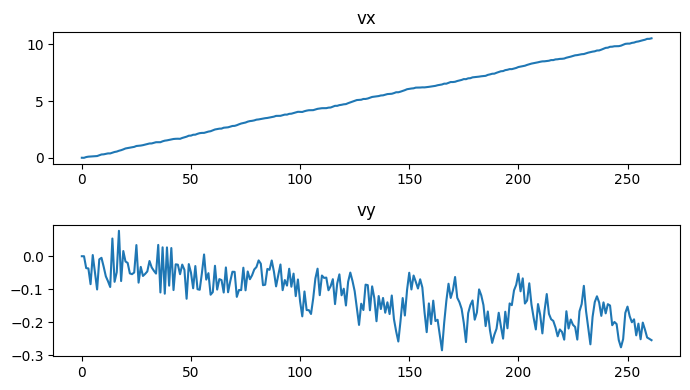

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4))
ax[0].plot(np.array(env.car.bicycle_model.car_traj_arr)[:, -2]);ax[0].set_title("vx")
ax[1].plot(np.array(env.car.bicycle_model.car_traj_arr)[:, -1]);ax[1].set_title("vy")
plt.tight_layout()

In [5]:
forward_vec = obs_dict['forward_vector'][-1]
lidar_sensor = obs_dict['lidar_sensor'][-1]
lookahead_kappa = obs_dict['lookahead_kappa'][-1]
print(lookahead_kappa)

[-5.05057543e-03  1.35230802e-02  4.16480631e-03 -1.00178869e-03
 -3.31813989e-03  8.19394241e-03  5.60092175e-03  1.03335949e-03
  2.04560965e-03 -5.46704022e-04 -2.32320985e-04  2.33123924e-03
  4.67340638e-03  5.76779509e-03  8.10783032e-03  3.89223278e-03
  1.67970717e-03  2.41603197e-04  4.40283781e-04  1.19846393e-03
 -2.28205598e-03 -2.21945109e-03  2.14906979e-02 -2.17279229e-02
 -2.28346753e-03  2.89972688e-02 -9.83579755e-05 -7.89247843e-04
 -2.44129202e-03 -3.61373523e-04]


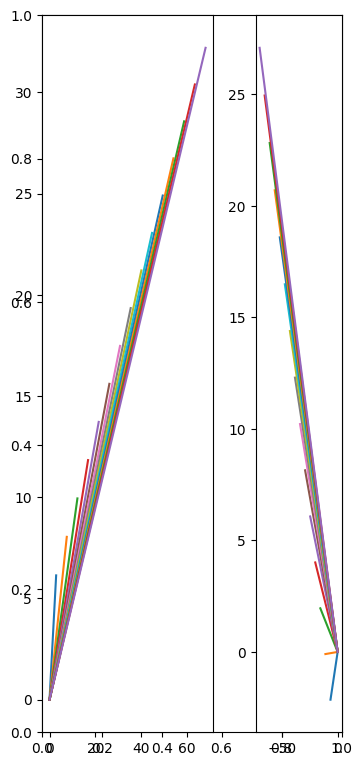

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
fixed_body = env.forward_vector_obj.vector_dict['fixed_body']
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
for i, (vx, vy) in enumerate(fixed_body):
    ax1.plot([0, vx], [0, vy])
inertia = env.forward_vector_obj.vector_dict['inertia']
for i, (vx, vy) in enumerate(inertia):
    ax2.plot([0, vx], [0, vy])
fig.tight_layout()

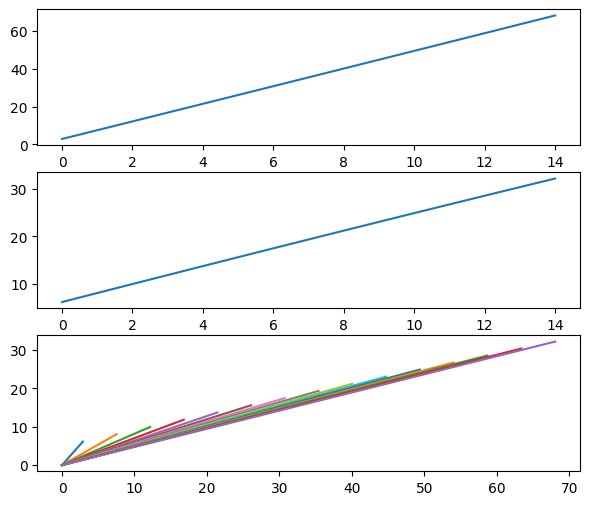

In [7]:
vec_x, vec_y = forward_vec[0::2], forward_vec[1::2]
fig, ax = plt.subplots(3, 1, figsize=(7, 6))
ax[0].plot(vec_x)
ax[1].plot(vec_y)
for (x, y) in zip(vec_x, vec_y):
    plt.plot([0, x], [0, y])

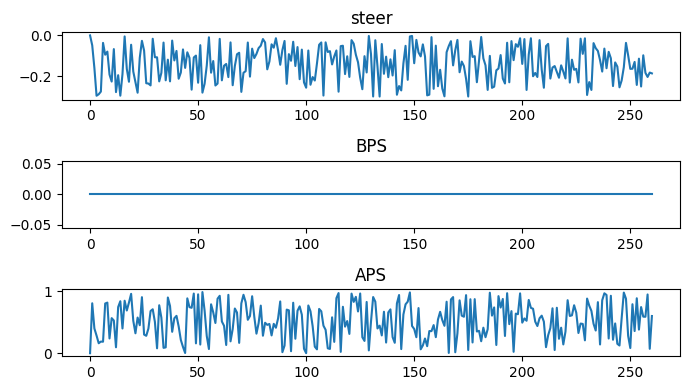

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4))
ax[0].plot(env.car.actions['steer']);ax[0].set_title("steer")
ax[1].plot(env.car.actions['brake']);ax[1].set_title("BPS")
ax[2].plot(env.car.actions['throttle']);ax[2].set_title("APS")
fig.tight_layout()

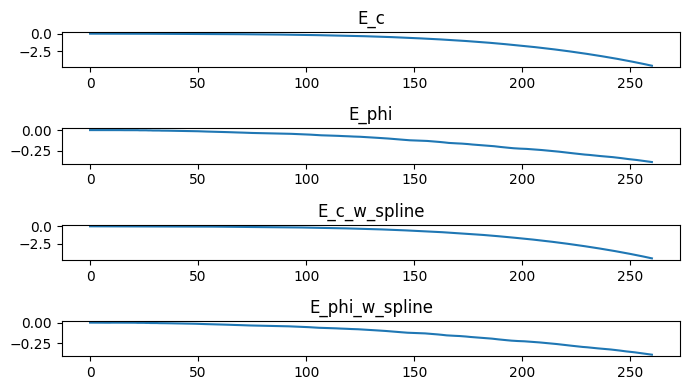

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(7, 4))
ax[0].plot(np.array(env.car.bicycle_model.e_c_arr));ax[0].set_title('E_c')
ax[1].plot(np.array(env.car.bicycle_model.e_phi_arr));ax[1].set_title('E_phi')
ax[2].plot(env.car.bicycle_model.Ec_w_spline_arr);ax[2].set_title('E_c_w_spline')
ax[3].plot(env.car.bicycle_model.Ephi_w_spline_arr);ax[3].set_title('E_phi_w_spline')

plt.tight_layout()


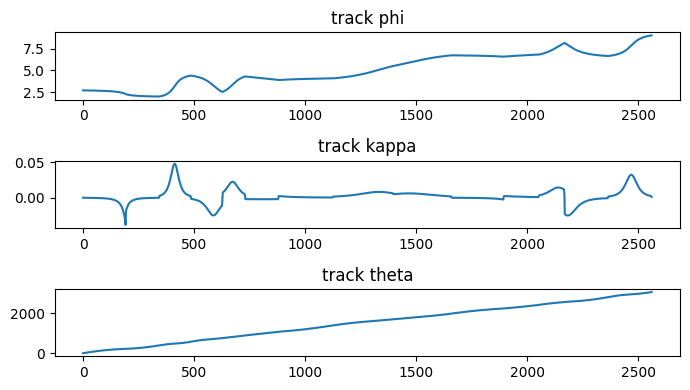

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4))
ax[0].plot(env.track_dict['phi']);ax[0].set_title("track phi")
ax[1].plot(env.track_dict['kappa']);ax[1].set_title("track kappa")
ax[2].plot(env.track_dict['theta']);ax[2].set_title("track theta")
fig.tight_layout()

Ref theta: 23.139707290875105


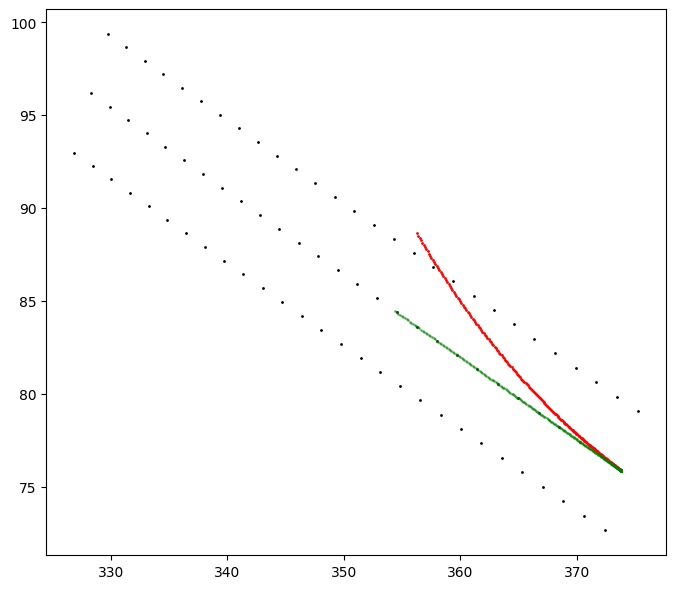

In [11]:
track_dict = env.track_dict
mx, Mx = min(track_dict['x']), max(track_dict['x'])
my, My = min(track_dict['y']), max(track_dict['y'])
dx, dy = Mx - mx, My - my

row, col = 8, 8 * (dy / dx)
fig, ax = plt.subplots(figsize=(row, col))

ref_theta = env.car.bicycle_model.ref_arr_dict['theta'][-1]
print(f"Ref theta: {ref_theta}")
for i, (X, Y) in enumerate(zip(track_dict['x'], track_dict['y'])):
    theta = track_dict['theta'][i]
    if min(track_dict['theta']) <= theta <= ref_theta + 30:
        plt.scatter(X, Y, s=1, c='k')
        plt.scatter(track_dict['left'][i][0], track_dict['left'][i][1], s=1, c='k')
        plt.scatter(track_dict['right'][i][0], track_dict['right'][i][1], s=1, c='k')
        
    else:
        continue

car_traj = np.array(env.car.bicycle_model.car_traj_arr)
for i, (X, Y) in enumerate(car_traj[:, :2]):
    plt.scatter(X, Y, s = 1, c='r')

ref_center = np.array(env.car.bicycle_model.ref_arr_dict['center'])
for i, (X, Y) in enumerate(ref_center):
    plt.scatter(X, Y, s=1, alpha=0.5, c='g')
    

In [12]:
phi_spline, kappa_spline = env.car.phi_spline, env.car.kappa_spline
theta_ref_arr = env.car.bicycle_model.ref_arr_dict['theta']

print(phi_spline(theta_ref_arr[0]), phi_spline(theta_ref_arr[50]))

2.7269189793077437 2.7268426397056706


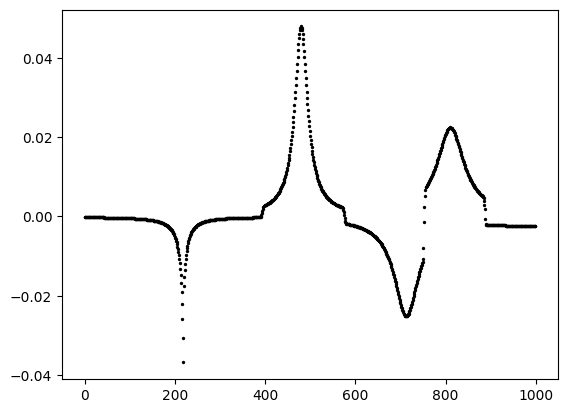

In [17]:
for i in range(0, 1000): 
    plt.scatter(x=i, y=kappa_spline(i), s=2, c='k')

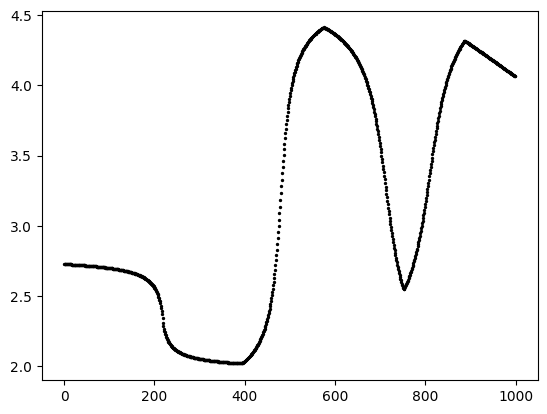

In [15]:
for i in range(0, 1000): 
    plt.scatter(x=i, y=phi_spline(i), s=2, c='k')

In [25]:
theta_ref_arr[0], theta_ref_arr[50]

(np.float64(1.9720758614576352), np.float64(2.763126630672345))

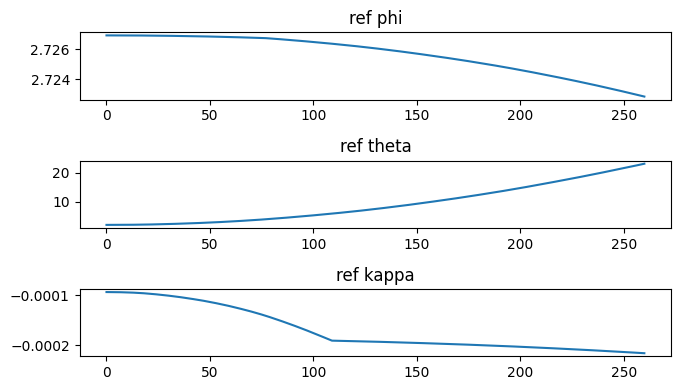

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(7, 4))
ax[0].plot(env.car.bicycle_model.ref_arr_dict['phi']);ax[0].set_title("ref phi")
ax[1].plot(env.car.bicycle_model.ref_arr_dict['theta']);ax[1].set_title("ref theta")
ax[2].plot(env.car.bicycle_model.ref_arr_dict['kappa']);ax[2].set_title("ref kappa")
fig.tight_layout()

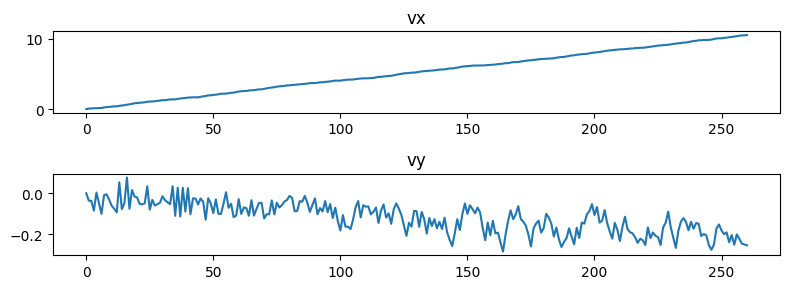

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1 , figsize=(8, 3))
ax[0].plot(obs_dict['vx']);ax[0].set_title("vx")
ax[1].plot(obs_dict['vy']);ax[1].set_title("vy")
plt.tight_layout()

In [36]:
mh_mlp = MultiHeadedMlp(
    hidden_sizes=[256, 256],
    output_sizes=[1, 1, 1],
    input_size=89
    
)

In [42]:
inp = torch.rand((32, 89))
out = mh_mlp(inp)
print(len(out))

3


In [45]:
out[0].shape

torch.Size([32, 1])

#### generate circle / oval tracks

In [3]:
import os, sys
sys.path.append(r'C:\Users\7459985\Desktop\2025\RDDS\001_code\meow_racer\step_1_2_rl_adv\environment'.replace('\\', '/'))
from track.generate_random import Random_TrackGenerator
import math
import matplotlib.pyplot as plt
import numpy as np

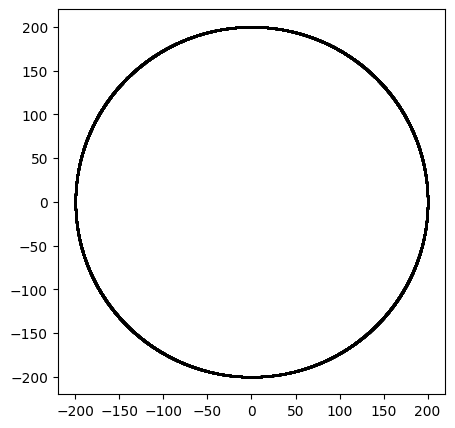

In [24]:
def _generate_circle_points(radius, d_angle_deg, start_deg:float=0):
    N = int(360 // d_angle_deg)
    center_x, center_y = [], []
    for n in range(N):
        deg = d_angle_deg * n + start_deg
        x = radius * math.cos(math.radians(deg))
        y = radius * math.sin(math.radians(deg))
        center_x.append(x)
        center_y.append(y)
    return np.array(center_x), np.array(center_y)


circle_X, circle_Y = _generate_circle_points(200, 0.05)
fig, ax = plt.subplots(figsize=(5,5))
for i, (x, y) in enumerate(zip(circle_X, circle_Y)):
    plt.scatter(x, y, s=1, c='k')
        
    

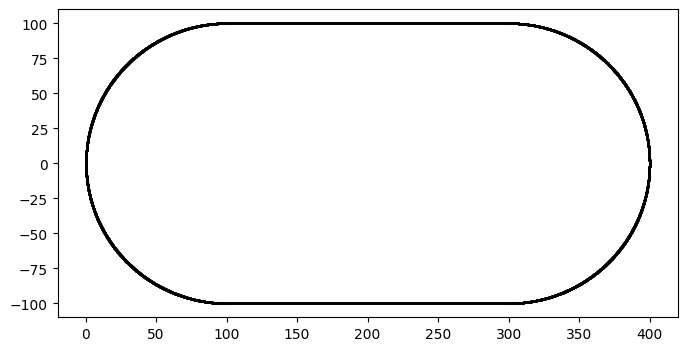

In [40]:
def _generate_oval_points(radius, straight_length, d_angle_deg, d_straight,
                          initial_phi_deg:float=0.):
    
    x, y = radius, -straight_length / 2
    
    #### (1) Right Part ####
    center_x, center_y = [x], [y]
    straight_N = straight_length / d_straight
    for n in range(int(straight_N)):
        x += d_straight * math.cos(math.radians(initial_phi_deg))
        y += d_straight * math.sin(math.radians(initial_phi_deg))
        center_x.append(x);center_y.append(y)
    
    circle_cx = center_x[-1] + math.cos(math.radians(90+initial_phi_deg)) * radius
    circle_cy = center_y[-1] + math.sin(math.radians(90+initial_phi_deg)) * radius
    
    circle_N = 180 / d_angle_deg
    deg = initial_phi_deg - 90
    
    for n in range(int(circle_N)):
        rad = math.radians(deg + n * d_angle_deg)
        center_x.append(circle_cx + radius*math.cos(rad))
        center_y.append(circle_cy + radius*math.sin(rad))
    
    
    #### (2) Left Part ####
    last_x, last_y = center_x[-1], center_y[-1]
    for n in range(int(straight_N)):
        last_x += d_straight * math.cos(math.radians(180 + initial_phi_deg))
        last_y += d_straight * math.sin(math.radians(180 + initial_phi_deg))
        center_x.append(last_x)
        center_y.append(last_y) 
        
    circle_cx = center_x[-1] + math.cos(math.radians(270+initial_phi_deg)) * radius
    circle_cy = center_y[-1] + math.sin(math.radians(270+initial_phi_deg)) * radius
    deg = initial_phi_deg + 90
    
    for n in range(int(circle_N)):
        rad = math.radians(deg + n * d_angle_deg)
        center_x.append(circle_cx + radius*math.cos(rad))
        center_y.append(circle_cy + radius*math.sin(rad))
        
    return np.array(center_x), np.array(center_y)


oval_x, oval_y = _generate_oval_points(
    radius=100, straight_length = 200,
    d_angle_deg=0.1, d_straight=0.5,
    initial_phi_deg=0
)
mx, Mx = min(oval_x), max(oval_x)
my, My = min(oval_y), max(oval_y)
dx, dy = Mx-mx, My-my
row, col = 8,  8 * (dy/dx)
fig, ax = plt.subplots(figsize=(row, col))
for i, (x, y) in enumerate(zip(oval_x, oval_y)):
    plt.scatter(x, y, s=1, c='k')

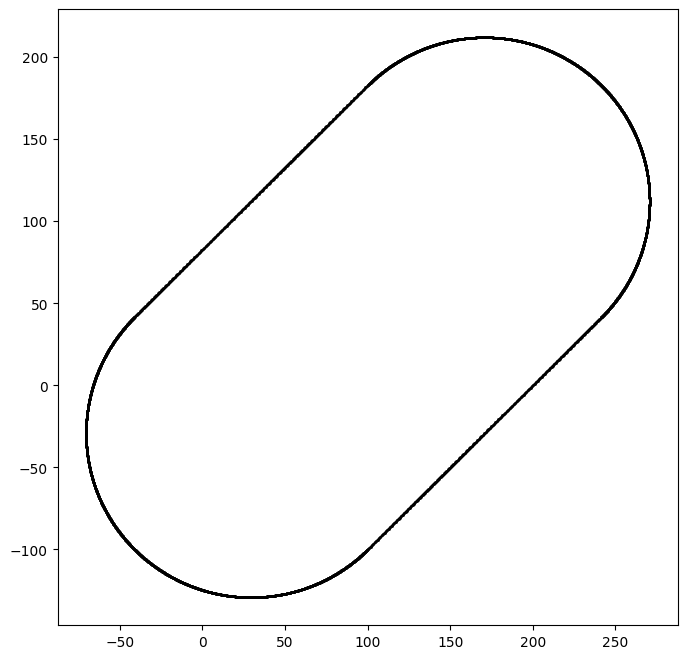

In [41]:
oval_x, oval_y = _generate_oval_points(
    radius=100, straight_length = 200,
    d_angle_deg=0.1, d_straight=0.5,
    initial_phi_deg=45
)
mx, Mx = min(oval_x), max(oval_x)
my, My = min(oval_y), max(oval_y)
dx, dy = Mx-mx, My-my
row, col = 8,  8 * (dy/dx)
fig, ax = plt.subplots(figsize=(row, col))
for i, (x, y) in enumerate(zip(oval_x, oval_y)):
    plt.scatter(x, y, s=1, c='k')

In [5]:
class Circle_TrackGenerator(Random_TrackGenerator):
    def __init__(self, 
                 track_width:float=7,
                 min_num_ckpt:int=4, 
                 max_num_ckpt:int=16):
        super().__init__(min_num_ckpt=min_num_ckpt, max_num_ckpt=max_num_ckpt, track_width=track_width)
    
    def _generate(self, radius, d_angle_deg, 
                  straight_length=None,
                  d_straight=None,
                  initial_phi_deg=None,
                  start_deg=0):
        self._reset()
        if straight_length is not None:
            self.cX, self.cY = self._generate_oval_points(
                radius, straight_length, d_angle_deg, d_straight, 
                initial_phi_deg
            )
        else:
            self.cX, self.cY = self._generate_circle_points(radius, d_angle_deg, start_deg)
        self.phi = self._get_track_phi()
        self.beta = self._get_track_beta()
        self.kappa = self._get_track_kappa()
        self.theta = self._get_track_theta()
        
    def _calculate_track_dict(self):
        self.vertice_arr, self.left_arr, self.right_arr = self._get_track_sides()
        track_dict = {
            'theta': self.theta, 
            'phi': self.phi,
            'beta': self.beta,
            'kappa': self.kappa,
            'x': self.cX, 'y': self.cY,
            'vertices': self.vertice_arr,
            'left': self.left_arr,
            'right': self.right_arr,
            'passed': np.zeros_like(self.theta)
        }
        return track_dict

    def _generate_oval_points(self, 
                              radius, straight_length, 
                              d_angle_deg, d_straight,
                              initial_phi_deg:float=0.):

        x, y = radius, -straight_length / 2

        #### (1) Right Part ####
        center_x, center_y = [x], [y]
        straight_N = straight_length / d_straight
        for n in range(int(straight_N)):
            x += d_straight * math.cos(math.radians(initial_phi_deg))
            y += d_straight * math.sin(math.radians(initial_phi_deg))
            center_x.append(x);center_y.append(y)

        circle_cx = center_x[-1] + math.cos(math.radians(90+initial_phi_deg)) * radius
        circle_cy = center_y[-1] + math.sin(math.radians(90+initial_phi_deg)) * radius

        circle_N = 180 / d_angle_deg
        deg = initial_phi_deg - 90

        for n in range(int(circle_N)):
            rad = math.radians(deg + n * d_angle_deg)
            center_x.append(circle_cx + radius*math.cos(rad))
            center_y.append(circle_cy + radius*math.sin(rad))


        #### (2) Left Part ####
        last_x, last_y = center_x[-1], center_y[-1]
        for n in range(int(straight_N)):
            last_x += d_straight * math.cos(math.radians(180 + initial_phi_deg))
            last_y += d_straight * math.sin(math.radians(180 + initial_phi_deg))
            center_x.append(last_x)
            center_y.append(last_y) 

        circle_cx = center_x[-1] + math.cos(math.radians(270+initial_phi_deg)) * radius
        circle_cy = center_y[-1] + math.sin(math.radians(270+initial_phi_deg)) * radius
        deg = initial_phi_deg + 90

        for n in range(int(circle_N)):
            rad = math.radians(deg + n * d_angle_deg)
            center_x.append(circle_cx + radius*math.cos(rad))
            center_y.append(circle_cy + radius*math.sin(rad))

        return np.array(center_x), np.array(center_y)

    def _generate_circle_points(self, radius, d_angle_deg, start_deg:float=0):
        N = int(360 // d_angle_deg)
        center_x, center_y = [], []
        for n in range(N):
            deg = d_angle_deg * n + start_deg
            x = radius * math.cos(math.radians(deg))
            y = radius * math.sin(math.radians(deg))
            center_x.append(x)
            center_y.append(y)
        
        return np.array(center_x), np.array(center_y) 
        
    def _get_track_center(self):
        return self.cX, self.cY
    
    def _get_track_beta(self):
        phi_arr = self._get_track_phi()
        beta_arr = phi_arr - (np.pi/2)
        return beta_arr
    

In [6]:
circle_gen = Circle_TrackGenerator()
circle_gen._generate(radius=100, d_angle_deg=0.1)
circle_track_dict = circle_gen._calculate_track_dict()


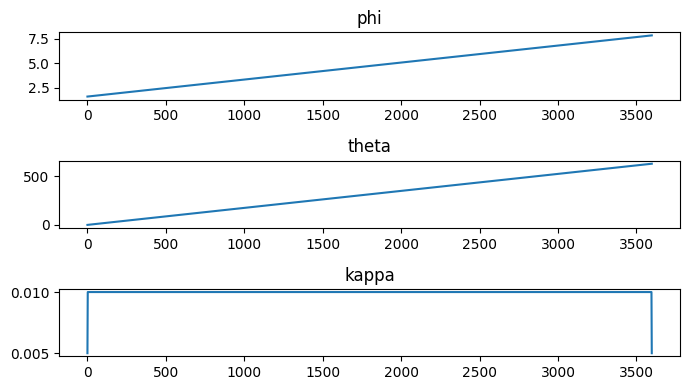

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(7,4))
ax[0].plot(circle_track_dict['phi']);ax[0].set_title("phi")
ax[1].plot(circle_track_dict['theta']);ax[1].set_title("theta")
ax[2].plot(circle_track_dict['kappa']);ax[2].set_title("kappa")
plt.tight_layout()

In [8]:
circle_gen = Circle_TrackGenerator()
circle_gen._generate(radius=10, d_angle_deg=3, straight_length=50, d_straight=1, initial_phi_deg=88)
oval_track_dict = circle_gen._calculate_track_dict()


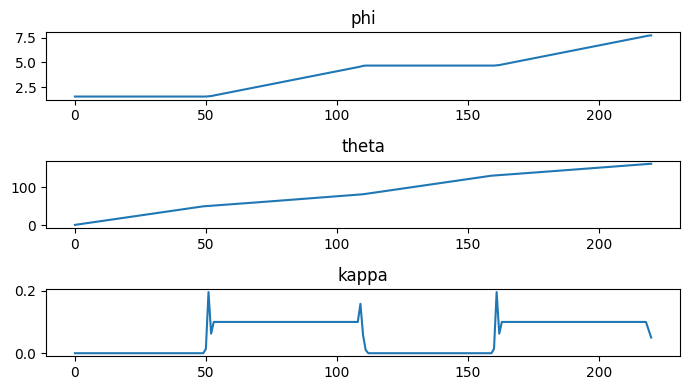

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(7,4))
ax[0].plot(oval_track_dict['phi']);ax[0].set_title("phi")
ax[1].plot(oval_track_dict['theta']);ax[1].set_title("theta")
ax[2].plot(oval_track_dict['kappa']);ax[2].set_title("kappa")
plt.tight_layout()

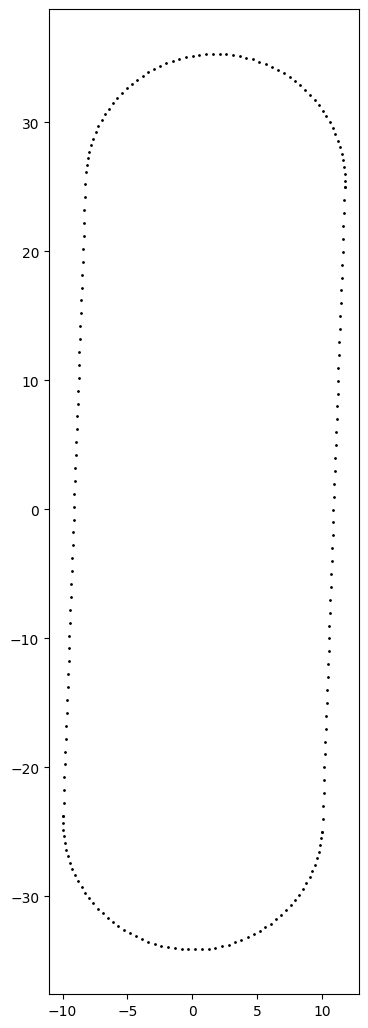

In [10]:
oval_x, oval_y = oval_track_dict['x'], oval_track_dict['y']
mx, Mx = min(oval_x), max(oval_x)
my, My = min(oval_y), max(oval_y)
dx, dy = Mx-mx, My-my
row, col = 4, 4* (dy/dx)
fig, ax = plt.subplots(figsize=(row, col))
for i, (x, y) in enumerate(zip(oval_x, oval_y)):
# for i, (x, y) in enumerate(zip(oval_x[:100], oval_y[:100])):
    
    plt.scatter(x, y, s=1, c='k')

In [11]:
from environment.vehicle.vehicle import RaceCar

car = RaceCar(action_dim=2, 
              dt=0.016,
              aps_bps_weight=1.,
              allow_both_feet=False,
              brake_on_pos_vel=True,
              normalize_aps_bps=False,
              schedule_brake_ratio=False,
              schedule_brake_ratio_scale=0.01,
              schedule_brake_episode=100,
              cfg_file_path=r'C:\Users\7459985\Desktop\2025\RDDS\001_code\meow_racer\step_1_2_rl_adv\environment\vehicle\jw_config.yaml'.replace('\\', '/')
              )

car._reset(track_dict=oval_track_dict)

In [50]:
import numpy as np
def generate_random_action(action_dim):
    # steer = np.random.uniform(-0.1, 0.1)
    # steer = np.random.uniform(-0.3, 0)
    steer = np.random.uniform(0, 0.3)
    if action_dim == 2:
        throttle = np.random.uniform(0., 1.)
        action = np.array([steer, throttle])
    else:
        aps = np.random.uniform(0.5, 1.)
        bps = np.random.uniform(-1., -0.5)
        action = np.array([steer, aps, bps])
    
    return action

MAX_NUM_STEP=500 
n_step = 0 #ObservationNormalization Wrapper로 싸지 않았기 때문에 원래 raw observation이 반환됨.
while n_step < MAX_NUM_STEP:
    # action = generate_random_action(environment_config['action']['action_dim'])
    action = generate_random_action(2)
    car._step(action)
    n_step += 1 

traj_arr =np.array(car.bicycle_model.car_traj_arr)


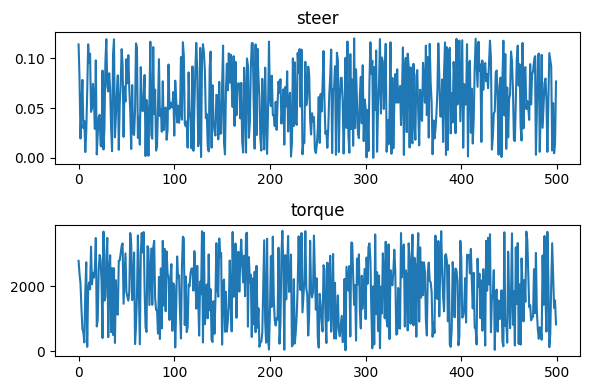

In [51]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(car.action2control['steer']);ax[0].set_title("steer")
ax[1].plot(car.action2control['torque']);ax[1].set_title("torque") 
plt.tight_layout()

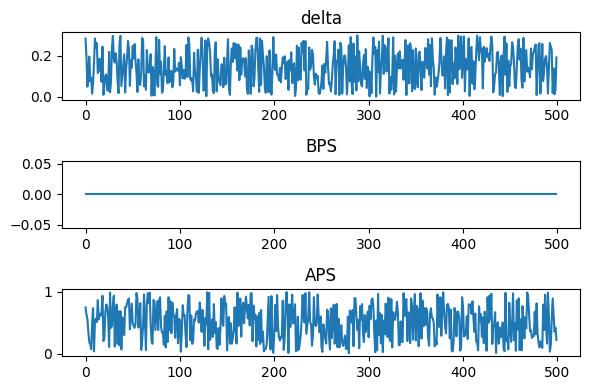

In [52]:
fig, ax = plt.subplots(3, 1, figsize=(6, 4))
ax[0].plot(car.actions['steer']);ax[0].set_title("delta")
ax[1].plot(car.actions['brake']);ax[1].set_title("BPS")
ax[2].plot(car.actions['throttle']);ax[2].set_title("APS")
plt.tight_layout()

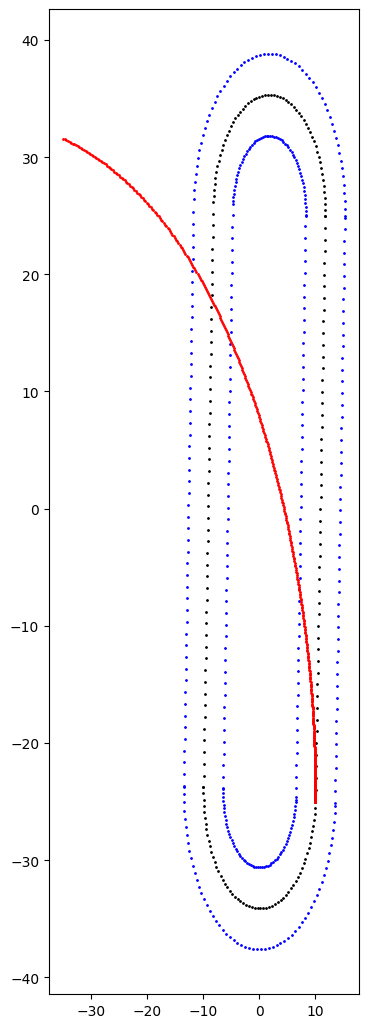

In [53]:
oval_x, oval_y = oval_track_dict['x'], oval_track_dict['y']
mx, Mx = min(oval_x), max(oval_x)
my, My = min(oval_y), max(oval_y)
dx, dy = Mx-mx, My-my
row, col = 4, 4* (dy/dx)
fig, ax = plt.subplots(figsize=(row, col))

for i, (x, y) in enumerate(zip(oval_x, oval_y)):
    plt.scatter(x, y, s=1, c='k')
    plt.scatter(oval_track_dict['left'][i][0], oval_track_dict['left'][i][1], s=1, c='b')
    plt.scatter(oval_track_dict['right'][i][0], oval_track_dict['right'][i][1], s=1, c='b')
    
for i, (x, y) in enumerate(zip(traj_arr[:, 0], traj_arr[:, 1])):
    plt.scatter(x, y, c='r', s=1)

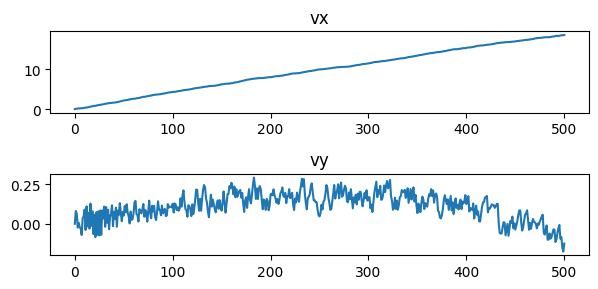

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(6, 3))
ax[0].plot(traj_arr[:, -2]);ax[0].set_title("vx")
ax[1].plot(traj_arr[:, -1]);ax[1].set_title("vy")
plt.tight_layout()

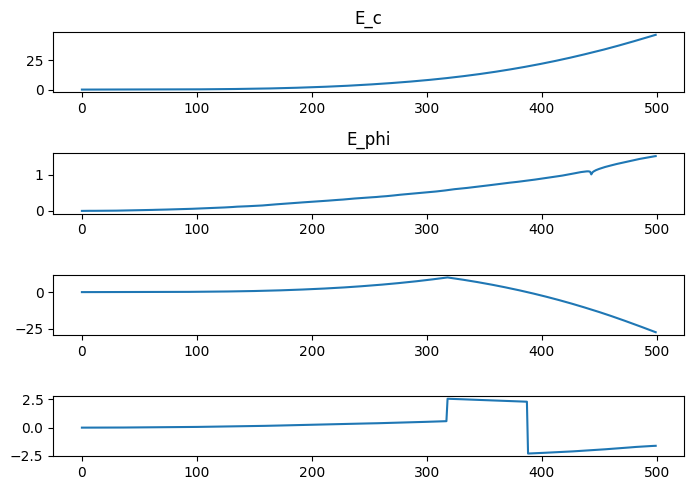

In [57]:
fig, ax = plt.subplots(4, 1, figsize=(7, 5))
ax[0].plot(car.bicycle_model.e_c_arr);ax[0].set_title("E_c")
ax[1].plot(car.bicycle_model.e_phi_arr);ax[1].set_title("E_phi")
ax[2].plot(car.bicycle_model.Ec_w_spline_arr)
ax[3].plot(car.bicycle_model.Ephi_w_spline_arr)
plt.tight_layout()